# Unsupervised Learning of Tactile Edge Orientation Detection

# MuJoCo Robotic Simulation Generating Synthetic Data
* Franka-Emika Panda

In [3]:
from IPython.display import Video

Video("../data/round_site.mp4")

# Non-rigid Tactile Sensor Simulation
1. $15 \times 15$ taxels simulated by damped spring particles

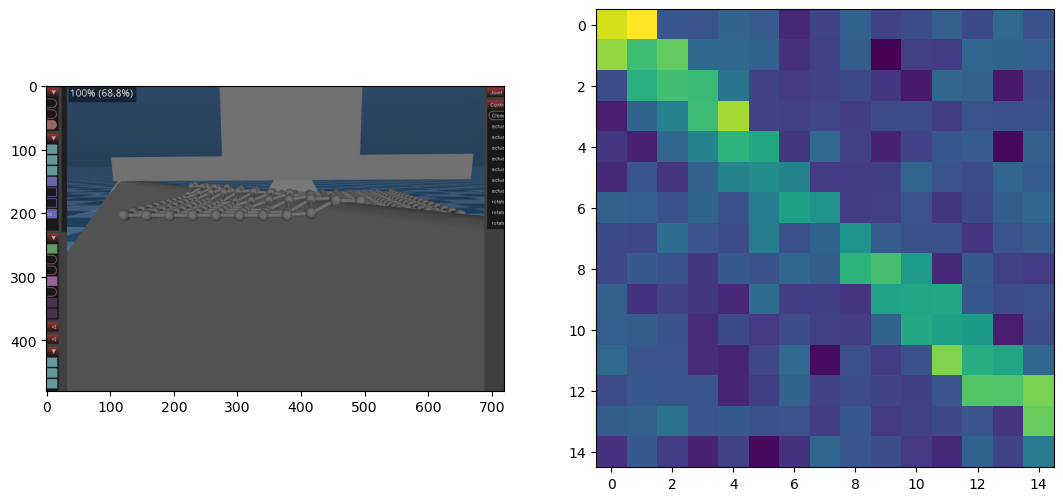

In [20]:
from matplotlib import pyplot as plt
from PIL import Image
from TouchDataset import TouchDataset

dataset = TouchDataset("../data/touch.pkl", flatten=False)
image = Image.open("../docs/softbody.png")
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(image)
axs[1].imshow(dataset[5000][0])
plt.show()

# One-hidden Layer Spiking Network
1. Binary input layer
2. Random receptive field - 25 neurons
3. Edge Orientation Output - 36 neurons

## Define Network structure and hyper-parameters

In [3]:
# Copyright 2022 wngfra.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
from brian2 import *

events = {"event3": ["increase_threshold", "v > v_th", "v_th += delta_theta*rand()"]}

params = {
    # Model constants
    "C_mem": 200 * pF,  # Membrane capacitance
    "delta_theta": 3 * mV,  # Adaptive threshold incremental scale
    "g_l": 10 * nS,  # Leak conductance
    "J_C": 1,  # Scale of the calcium variable
    "tau_c": 60 * ms,  # Calcium variable time constant
    "tau_e": 10 * ms,  # Excitatory synaptic time constant
    "tau_i": 10 * ms,  # Inhibitory synaptic time constant
    "tau_r": 5 * ms,  # Refractory period
    "tau_theta": 5 * ms,  # Adaptive threshold time constant
    "V_ir": -80 * mV,  # Inhibitory reverse potential
    "V_res": -65 * mV,  # Resting potential
    "V_theta": -55 * mV,  # Spiking threshold
    "w_e": 20 * nS,  # Excitatory conductance increment
    "w_i": 30 * nS,  # Inhibitory conductance increment
    "X_max": 1,  # Synaptic variable maximum
    "X_min": 0,  # Synaptic variable minimum
    # Simulation parameters
    "defaultclock.dt": 0.1 * ms,  # Time step
}

# Thresholds and plasticity parameters
params["a"] = 0.1 * params["X_max"]
params["b"] = 0.1 * params["X_max"]
params["alpha"] = 3.5 * params["X_max"] * Hz
params["beta"] = 3.5 * params["X_max"] * Hz
params["theta_hup"] = 12 * params["J_C"]
params["theta_lup"] = 3 * params["J_C"]
params["theta_hdown"] = 4 * params["J_C"]
params["theta_ldown"] = 3 * params["J_C"]
params["theta_v"] = 0.8 * params["V_theta"]
params["theta_X"] = 0.5 * params["X_max"]

eqs = {
    # Neuronal models
    "L1": """
        dv/dt = (g_l*(V_res - v) + I(t,i))/C_mem : volt (unless refractory)
        x : 1
        y : 1
        """,
    "L2": """
        dv/dt = (g_l*(V_res - v) - g_e*v)/C_mem : volt (unless refractory)
        dg_e/dt = -g_e/tau_e : siemens
        sum_w : 1
        x : 1
        y : 1
        """,
    "L3": """
        dv/dt = (g_l*(V_res - v) - g_e*v + g_i*(V_ir - v))/C_mem : volt (unless refractory)
        dg_e/dt = -g_e/tau_e : siemens
        dg_i/dt = -g_i/tau_i : siemens
        dv_th/dt = (V_theta - v_th)/tau_theta : volt
        sum_w : 1
        """,
    # Synaptic models
    "Syn12": """
        w : 1
        sum_w_post = w : 1 (summed)
        """,
    "Syn23": """
        count : 1
        X_condition : 1
        dc/dt = -c/tau_c + J_C*count*Hz: 1 (clock-driven)
        dX/dt = (alpha*int(X > theta_X)*int(X < X_max) - beta*int(X <= theta_X)*int(X > X_min))*(1 - X_condition) : 1 (clock-driven)
        w = int(X >= 0.5) : 1
        sum_w_post = w : 1 (summed)
        """,
    "Syn33": """
        w : 1
        """,
    # Synaptic events
    "Pre12": """
        g_e_post += w_e/sum_w_post
        """,
    "Pre23": """
        g_e_post += w_e*int(sum_w_post >= 1)/(sum_w_post + 1e-13)*X
        X += a*int(v_pre > theta_v)*int(theta_lup < c)*int(c < theta_hup) - b*int(v_pre <= theta_v)*int(theta_ldown < c)*int(c < theta_hdown)
        X = clip(X, X_min, X_max)
        X_condition = int(v_pre > theta_v)*int(theta_lup < c)*int(c < theta_hup) + int(v_pre <= theta_v)*int(theta_ldown < c)*int(c < theta_hdown)
        """,
    "Pre33": """
        g_i_post += w_i*abs(i-j)
        """,
    "Post23": """
        count += 1
        X_condition = 0
        """,
}

connections = {
    "Syn12": {"mode": "balanced_random"},
    "Syn23": {"mode": "full"},
    "Syn33": {"mode": "different"},
}

recordings = {
    "L1": ["v"],
    "L2": ["v"],
    "L3": ["v"],
    "Syn23": ["X", "w"],
}

initial_values = {
    "L1": {"v": "V_res + rand()*(V_theta - V_res)"},
    "L2": {"v": "V_res + rand()*(V_theta - V_res)"},
    "L3": {
        "v": "V_res + rand()*(V_theta - V_res)",
        "v_th": "V_theta",
        "g_e": 0 * nS,
        "g_i": 0 * nS,
    },
    "Syn12": {"w": 1},
    "Syn23": {"count": 0, "c": 2, "X": "rand()*X_max", "delay": "rand()*tau_r"},
    "Syn33": {"w": 1},
}


def generate_conns(N, M, mode="full"):
    """Generate connection patterns for the Synapses.

    Parameters
    ----------
        N : int
            Number of incoming synapses.
        M : int
            Number of outgoing synapses.
        mode : {'different', 'full', 'random'}, default='full'
            Connection mode.

    Returns
    -------
        i, j, condition, p: (int, int, str, float)
            Synaptic connection configs.

    """
    i, j = None, None
    condition = None
    p = 1.0

    match mode:
        case "different":
            condition = "i != j"
        case "full":
            i = np.repeat(np.arange(N), M)
            j = np.tile(np.arange(M), N)
        case "gaussian":
            p = "1.0 * exp(-((x_pre-x_post)**2 + (y_pre-y_post)**2)/(sqrt(2)*rf_size**2))"
        case "random":
            p = "rand()"
        case "balanced_random":
            i = np.arange(N)
            np.random.shuffle(i)
            j = np.zeros(N, dtype=int)
            j[0 : N // M * M] = np.repeat(np.arange(M), N // M)

    return i, j, condition, p


class TacNet(object):
    def __init__(self, num_neurons: list, stimuli, receptive_field="random") -> None:
        """Constructor of the Tactile Encoding Network.

        Parameters
        ----------
            num_neurons : list of int
                List of numbers of neurons of each layer. 'L1' is the input layer.
        """

        try:
            device.reinit()
            device.activate()
        except _:
            pass

        params["I"] = stimuli
        connections["Syn12"]["mode"] = receptive_field

        # Define NeuronGroups (layers)
        neuron_groups = {}
        for index, n_neuron in enumerate(num_neurons):
            layer_name = "L%d" % (index + 1)
            event_name = "event%d" % (index + 1)

            if event_name in events:
                event_label = events[event_name][0]
                event_trigger = events[event_name][1]
                event_operation = events[event_name][2]
                event = {event_label: event_trigger}
            else:
                event = None
            neuron_groups[layer_name] = NeuronGroup(
                n_neuron,
                model=eqs[layer_name],
                method="euler",
                threshold="v > V_theta",
                reset="v = V_res",
                refractory="tau_r",
                events=event,
                namespace=params,
                name=layer_name,
            )
            if event is not None:
                neuron_groups[layer_name].run_on_event(event_label, event_operation)

        # Assign coordinates to L1 neurons
        l1_size = sqrt(len(neuron_groups["L1"]))
        l2_size = sqrt(len(neuron_groups["L2"]))
        rf_size = l1_size / l2_size

        neuron_groups["L1"].x = "i // l1_size"
        neuron_groups["L1"].y = "i % l1_size"
        neuron_groups["L2"].x = "rf_size // 2 + rf_size * (i // l2_size)"
        neuron_groups["L2"].y = "rf_size // 2 + rf_size * (i % l2_size)"

        # Define Synapses
        synapses = {}
        for source in range(len(num_neurons)):
            for target in range(len(num_neurons)):
                link = "%d%d" % (source + 1, target + 1)
                syn_name = "Syn" + link
                pre_name = "Pre" + link
                post_name = "Post" + link
                if syn_name in eqs:
                    if pre_name in eqs:
                        on_pre = eqs[pre_name]
                    else:
                        on_pre = None
                    if post_name in eqs:
                        on_post = eqs[post_name]
                    else:
                        on_post = None
                    synapses[syn_name] = Synapses(
                        neuron_groups["L%d" % (source + 1)],
                        neuron_groups["L%d" % (target + 1)],
                        model=eqs[syn_name],
                        on_pre=on_pre,
                        on_post=on_post,
                        namespace=params,
                        method="euler",
                        name=syn_name,
                    )

        # Connect synapses
        for synapse in synapses.values():
            mode = connections[synapse.name]["mode"]
            source, target, condition, p = generate_conns(
                synapse.source.N, synapse.target.N, mode=mode
            )
            synapse.connect(i=source, j=target, condition=condition, p=p)

        # Define Monitors
        self.mons = dict()
        for layer in neuron_groups.values():
            mon_name = "SpikeMonitor_" + layer.name
            self.mons[mon_name] = SpikeMonitor(layer, record=True, name=mon_name)
        for k, v in recordings.items():
            mon_name = "StateMonitor_" + k
            if k in neuron_groups:
                G = neuron_groups[k]
                record = True
            if k in synapses:
                G = synapses[k]
                record = np.arange(G.source.N * G.target.N)
            if "G" in locals():
                self.mons[mon_name] = StateMonitor(G, v, record=record, name=mon_name)

        # Add all groups to the network
        self.net = Network()
        for layer in neuron_groups.values():
            self.net.add(layer)
        for synapse in synapses.values():
            self.net.add(synapse)
        for monitor in self.mons.values():
            self.net.add(monitor)

        self.initiate(initial_values)

    def initiate(self, initial_values: dict):
        """Set initial values for the simulator.

        Parameters
            initial_values (dict): _description_
        """
        for k, iv_dict in initial_values.items():
            for attr, iv in iv_dict.items():
                setattr(self.net[k], attr, iv)

    def run(self, duration, save_state=None):
        """Run the simulation for a duration and save the state(optional).

        Parameters
            duration (Quantity): Time to run the simulation.
            save_state (str): Filepath to save the state. Defaults to None.

        Returns
            dict: A dictionary of Monitors.
        """
        self.net.run(duration=duration)
        return self.mons

## Run simulations

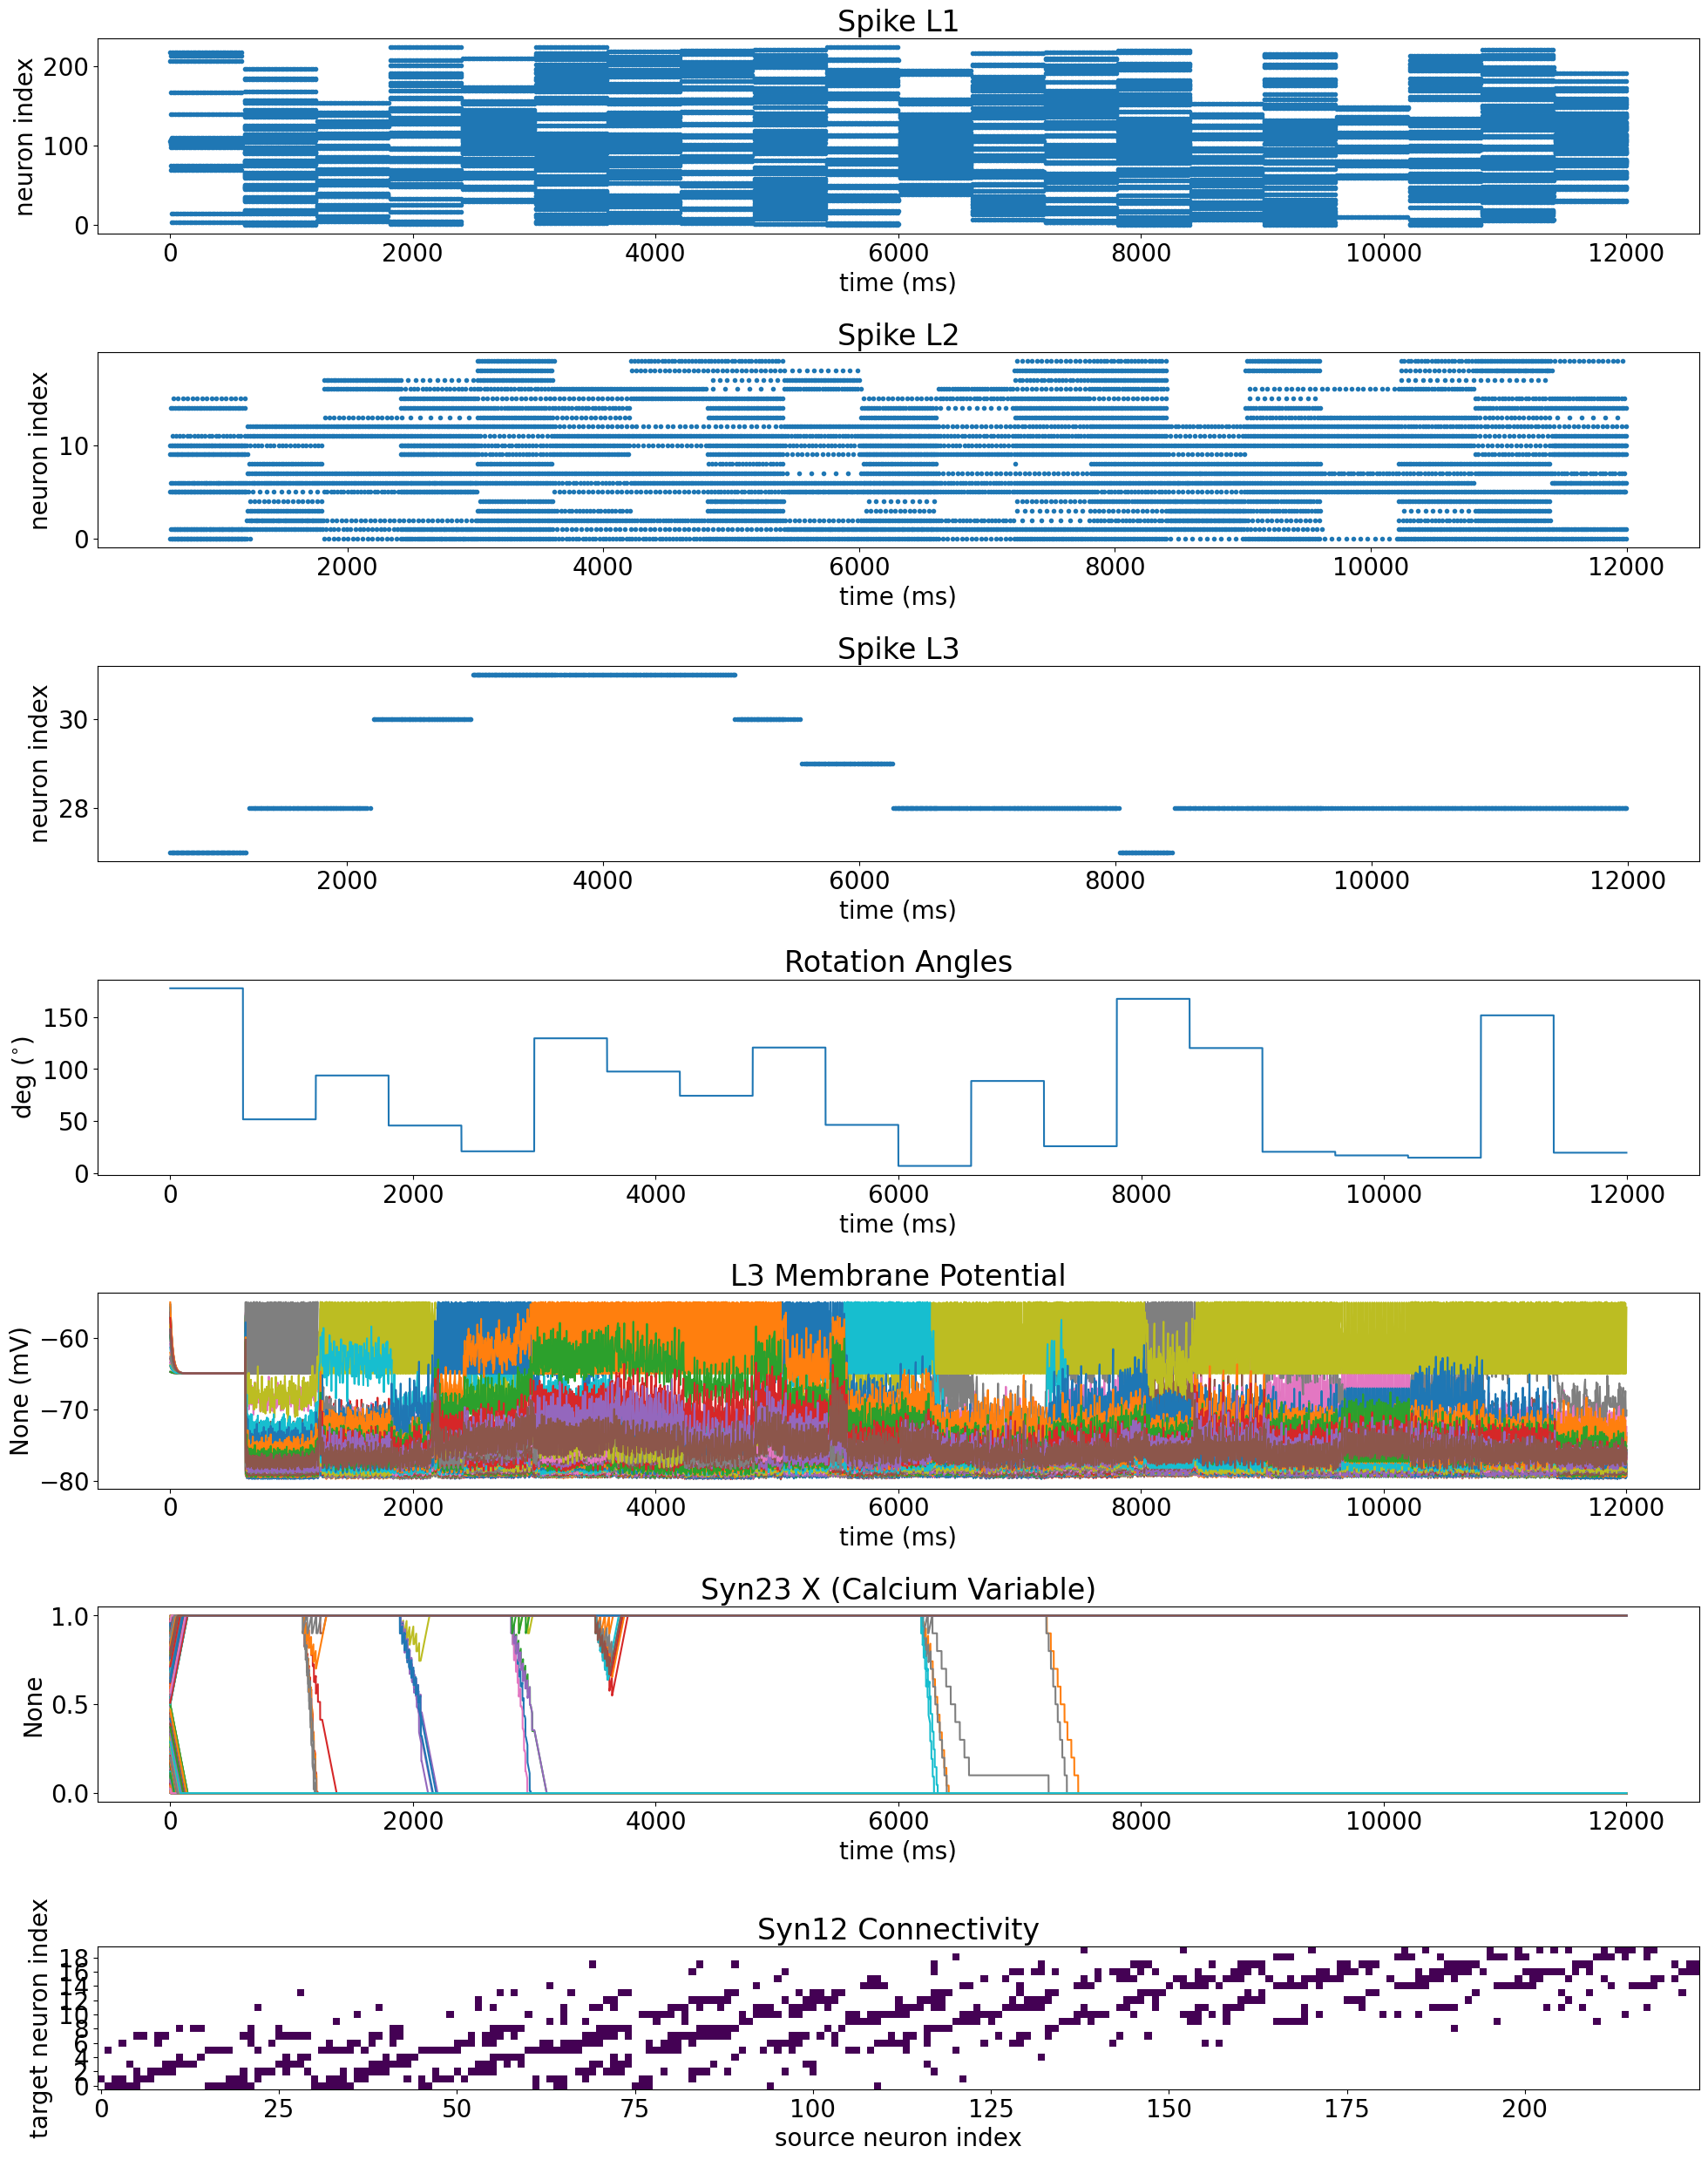

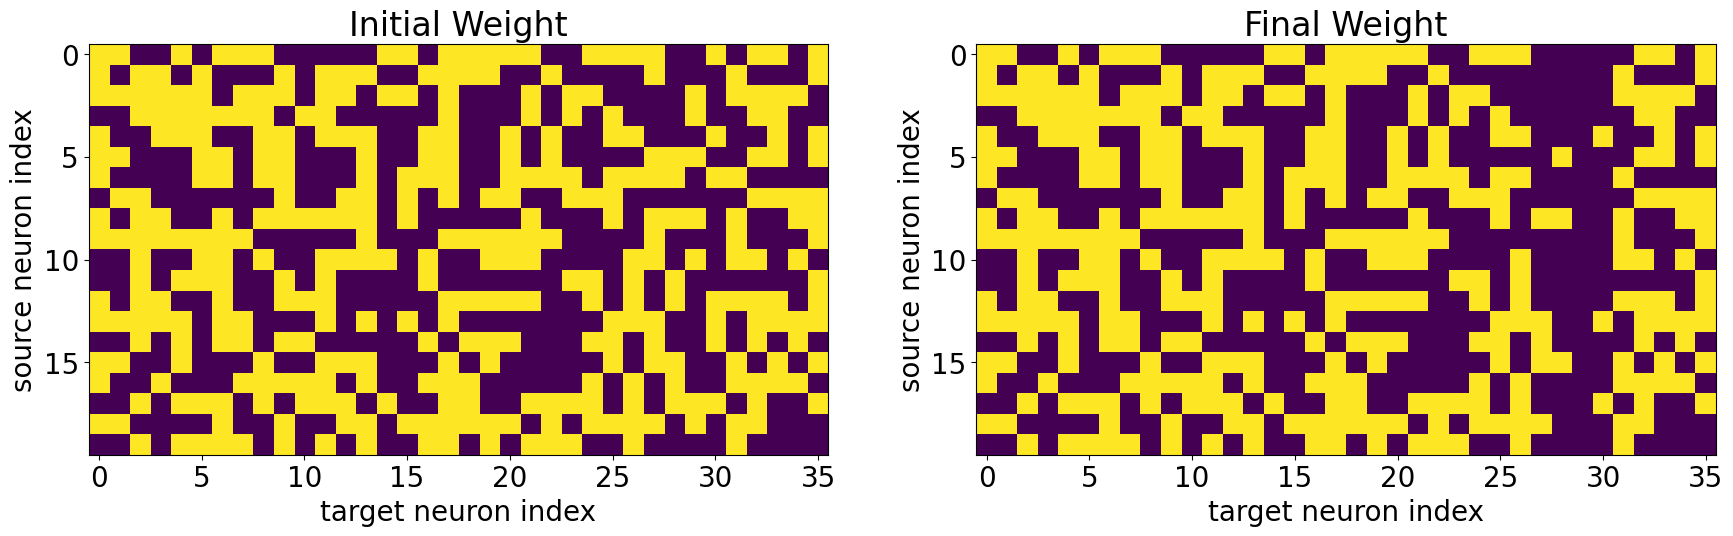

In [6]:
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from TouchDataset import TouchDataset

matplotlib.rcParams.update({"font.size": 20})

# prefs.devices.cpp_standalone.openmp_threads = 3
set_device("cpp_standalone")


def wrap2deg(rad):
    theta = np.array(rad)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return (theta - n * np.pi) / np.pi * 180


# Prepare dataset
N = 12000
n = 600  # repetition of stimuli
dataset = TouchDataset(filepath="../data/touch.pkl", noise_level=0.25, scope=(0.0, 1.0))
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.5)

samples, orientations = np.repeat(X_train[: N // n, :, :], n, axis=0), np.repeat(
    y_train[: N // n], n, axis=0
)

# Prepare simulation
# Convert values to spikes
dt = 1 * ms
duration = N * ms
length, height, width = samples.shape
inputs = samples.reshape(length, -1)
inputs[inputs > inputs.mean()] = 1
inputs[inputs < 1] = 0

I = TimedArray(inputs * 200 * pA, dt=dt)
num_neurons = [height * width, 20, 36]
model = TacNet(num_neurons, I, receptive_field="gaussian")
total_time = I.values.shape[0] * dt
mons = model.run(duration)

# Plot results
fig, axs = plt.subplots(7, 1, figsize=(20, 25))
for i in range(3):
    axs[i].set_title("Spike L" + str(i + 1))
    brian_plot(mons["SpikeMonitor_L" + str(i + 1)], axes=axs[i])

axs[3].plot(wrap2deg(orientations[: int(duration / dt)]))
axs[3].set_title("Rotation Angles")
axs[3].set_xlabel("time (ms)")
axs[3].set_ylabel(r"deg ($^{\circ}$)")
axs[4].set_title("L3 Membrane Potential")
plot_state(mons["StateMonitor_L3"].t, mons["StateMonitor_L3"].v.T, axes=axs[4])
axs[5].set_title("Syn23 X (Calcium Variable)")
plot_state(mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[5])
axs[6].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[6])
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(21, 15))
axes[0].imshow(
    mons["StateMonitor_Syn23"].w_[:, 0].reshape((num_neurons[1], num_neurons[2]))
)
axes[0].set_title("Initial Weight")
axes[1].imshow(
    mons["StateMonitor_Syn23"].w_[:, -1].reshape((num_neurons[1], num_neurons[2]))
)
axes[1].set_title("Final Weight")
for i in range(2):
    axes[i].set_xlabel("target neuron index")
    axes[i].set_ylabel("source neuron index")

plt.show()

# Reference
[1] A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.

[2] X. She, S. Dash, D. Kim, and S. Mukhopadhyay, “A Heterogeneous Spiking Neural Network for Unsupervised Learning of Spatiotemporal Patterns,” Front. Neurosci., vol. 14, p. 615756, Jan. 2021, doi: 10.3389/fnins.2020.615756.

[3] J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.

[4] J. A. Pruszynski, J. R. Flanagan, and R. S. Johansson, “Fast and accurate edge orientation processing during object manipulation,” eLife, vol. 7, p. e31200, Apr. 2018, doi: 10.7554/eLife.31200.

[5] J. Platkiewicz, “Haptic Edge Detection Through Shear,” Scientific Reports, p. 10.

[6] J. M. Brader, W. Senn, and S. Fusi, “Learning Real-World Stimuli in a Neural Network with Spike-Driven Synaptic Dynamics,” Neural Computation, vol. 19, no. 11, pp. 2881–2912, Nov. 2007, doi: 10.1162/neco.2007.19.11.2881.

[7] T. Barbier, C. Teuliere, and J. Triesch, “Spike timing-based unsupervised learning of orientation, disparity, and motion representations in a spiking neural network,” in 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), Nashville, TN, USA, Jun. 2021, pp. 1377–1386. doi: 10.1109/CVPRW53098.2021.00152.